In [2]:
from __future__ import print_function, absolute_import, division

import re
import math
import random
import time
import os
import pickle
import sys

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import h5py
import pylab as pl
import glob
import bisect
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable


import tensorflow as tf
import keras
from keras.models import load_model
##from sklearn import metrics
from collections import Counter

#root
absPath = '/home/angela/padding_EBI/'
sys.path.insert(0, absPath)

from src.Target import Target
from src.preprocessing import *

np.random.seed(8)
random.seed(8)

%matplotlib inline

Using TensorFlow backend.


In [3]:
# test with post_padding

#type_padding = "post_padding"

### Defining parameters 

In [27]:
list_paddings = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding', 'ext_padding', 
                 'rnd_padding', 'aug_padding', "zoom_padding"]

#list_paddings = ["post_padding"]
#hierarchy of folders: annotation/dataset/architecture/n_neurs/task/padding
folder = 'EC_number/archaea/3denses/bio_neurons/'#'EC_number/archaea/1conv/64filts_size5/'
column = "EC number"

n_folds = 10

dicti = creating_dict()

max_lenn = 1000

epochss = 200

task = "task1/"
architecture = "only_denses"
#architecture = "conv_dense"

In [28]:
#falta hacerlo por tipo de padding

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


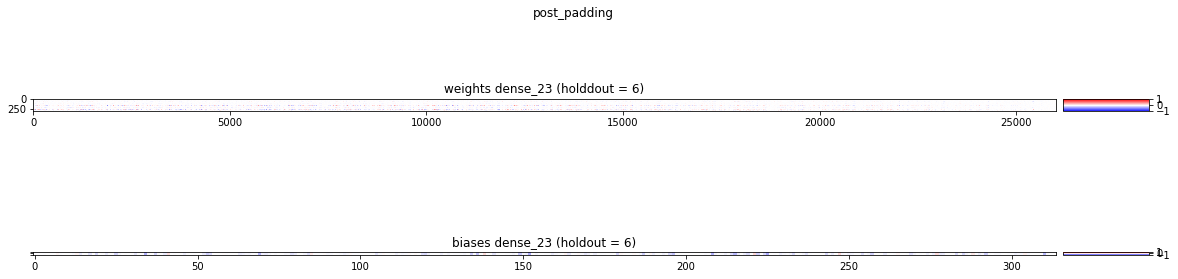

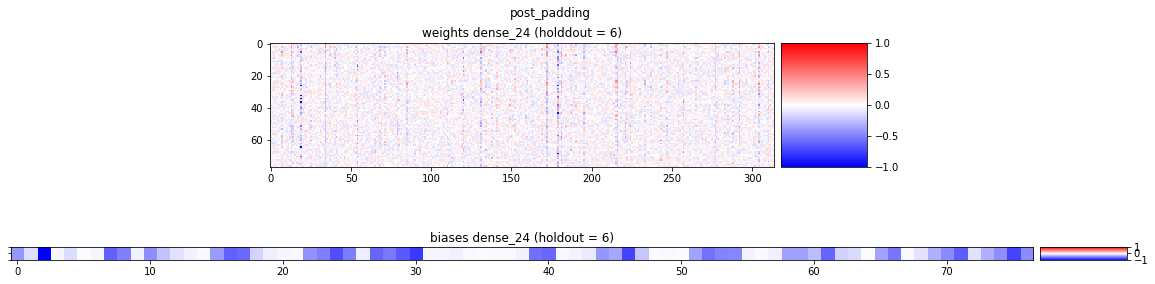

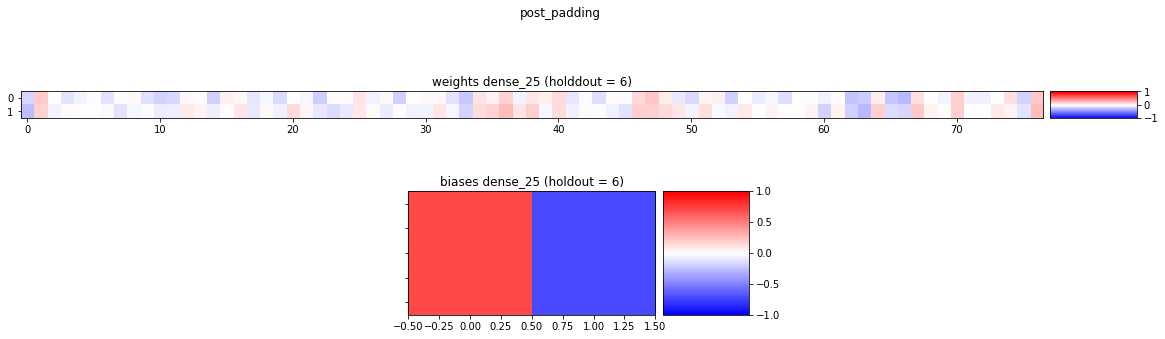

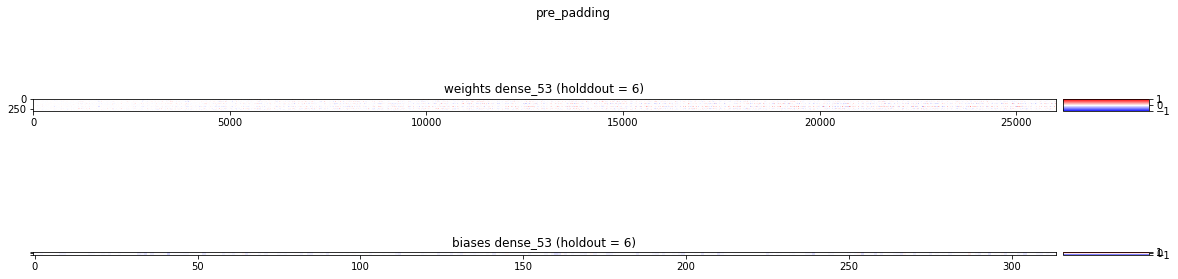

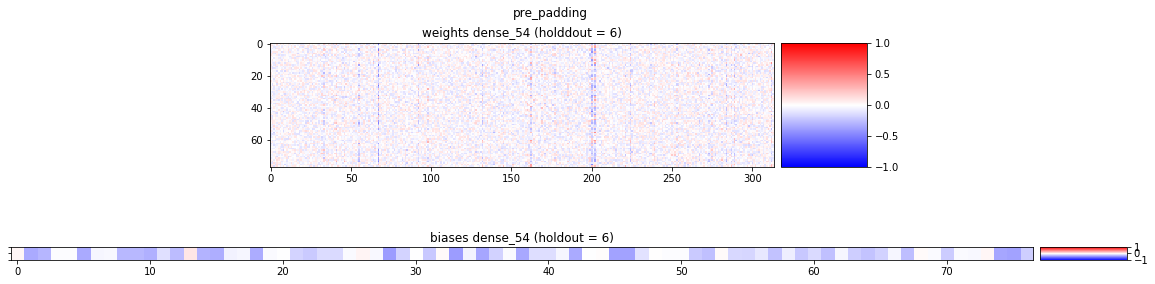

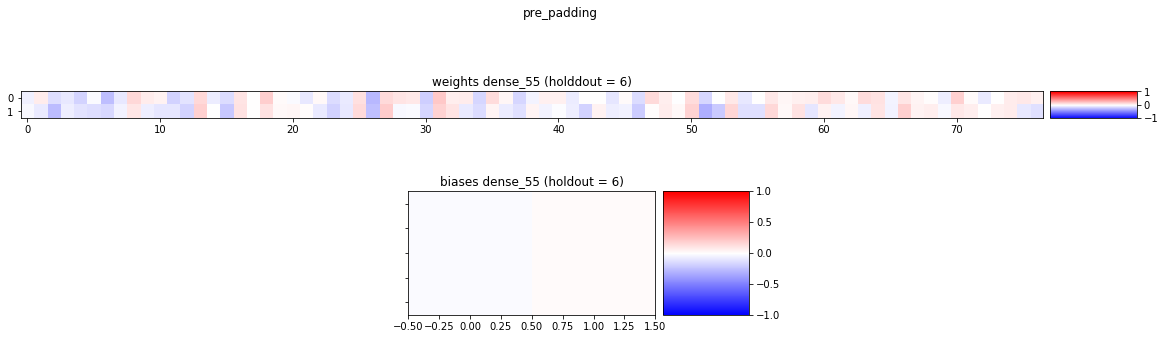

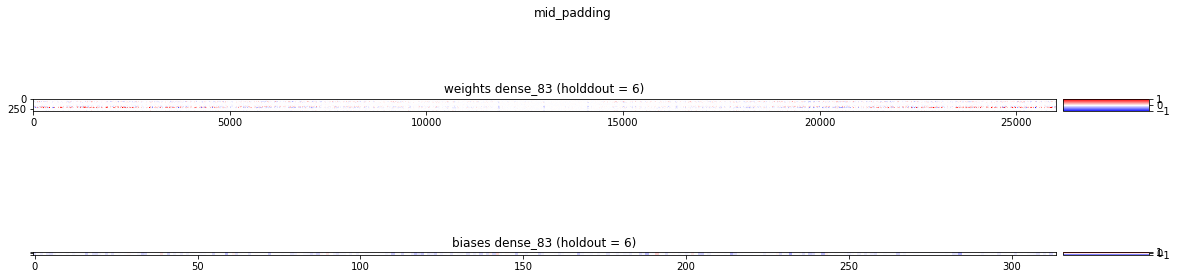

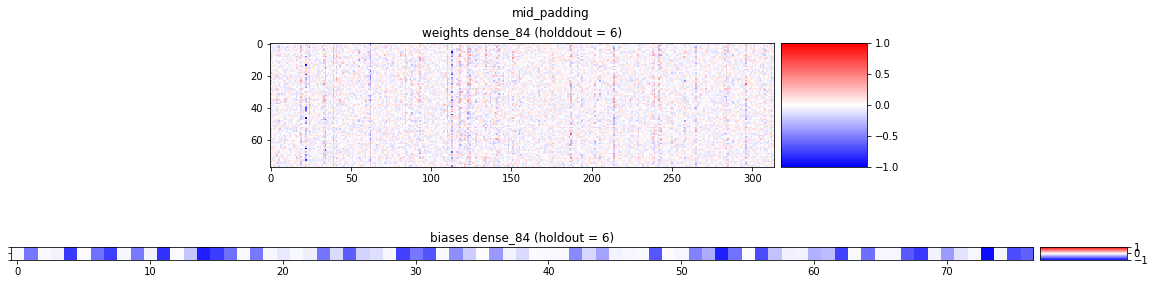

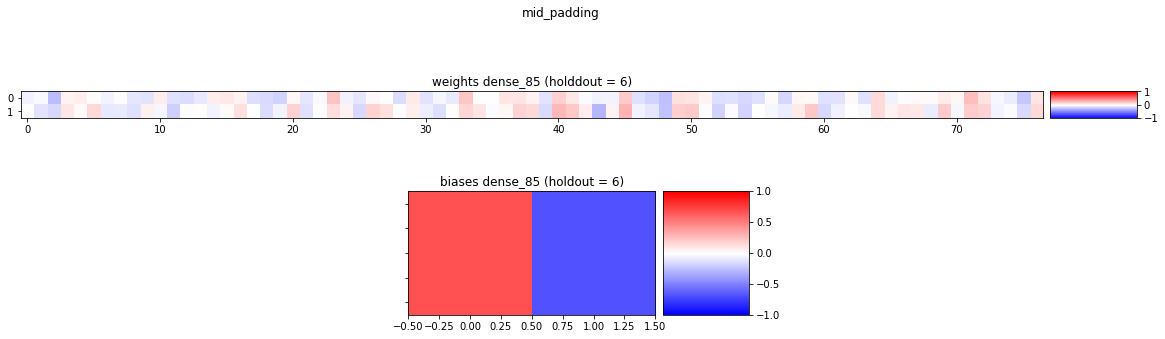

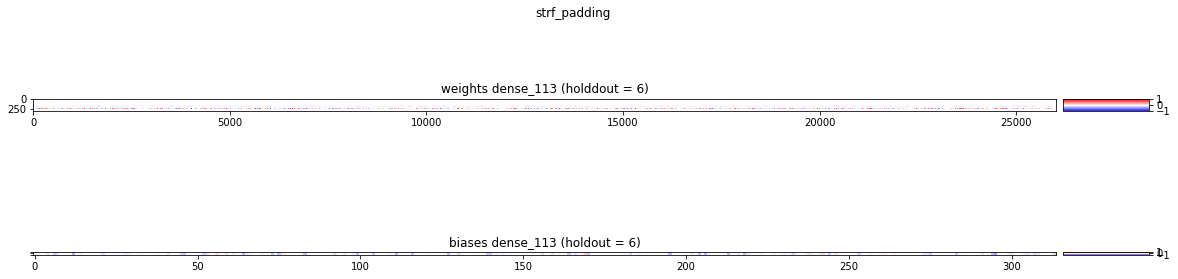

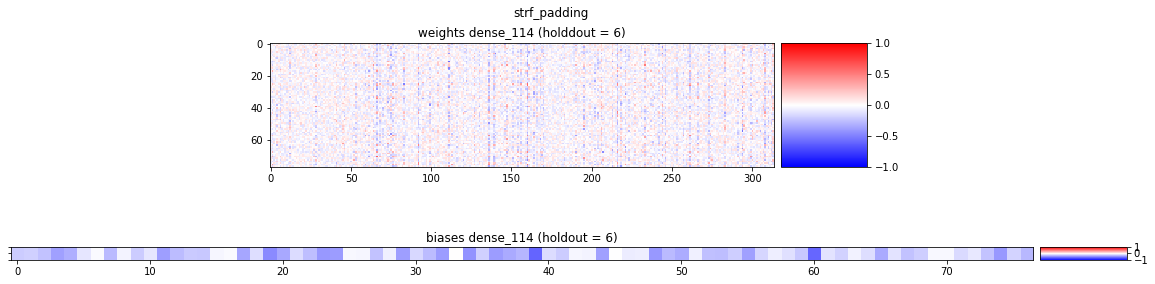

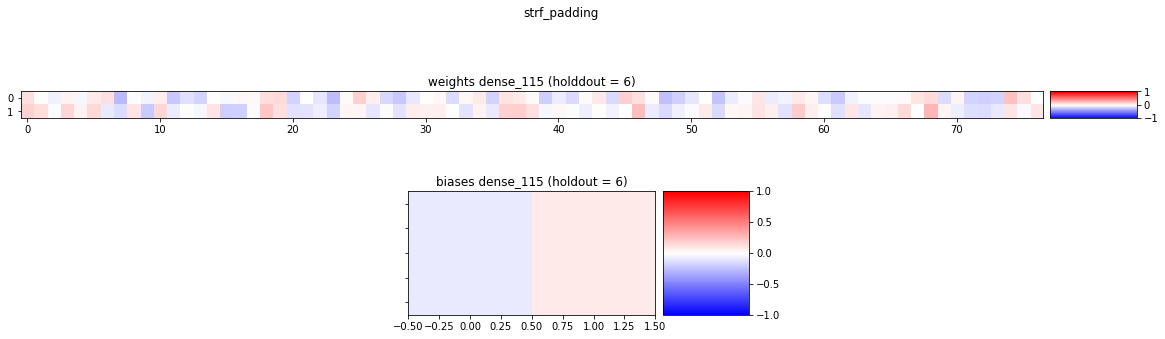

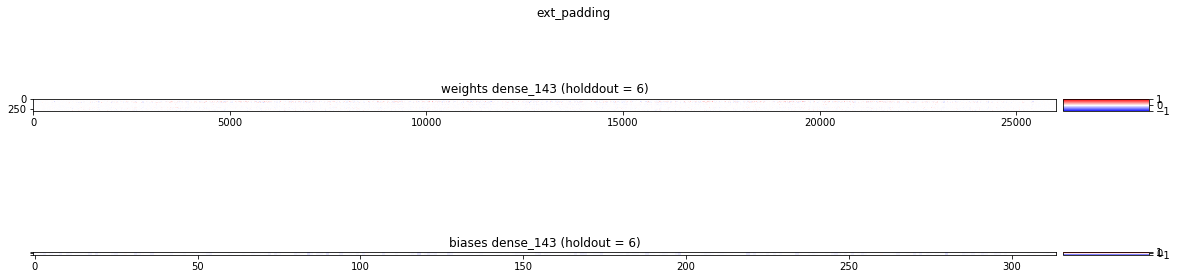

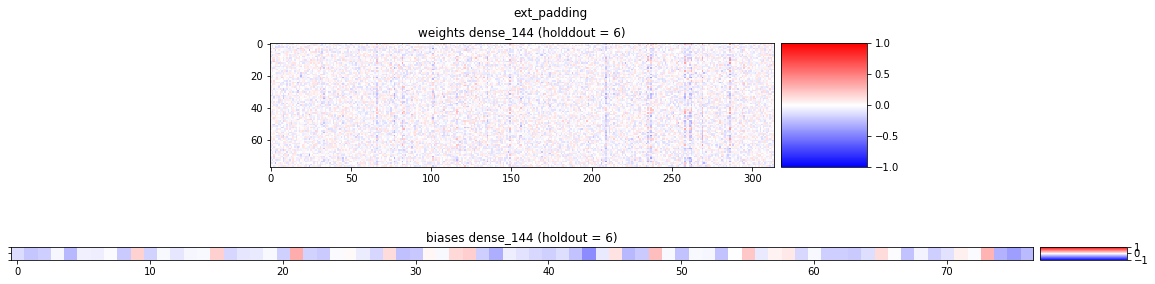

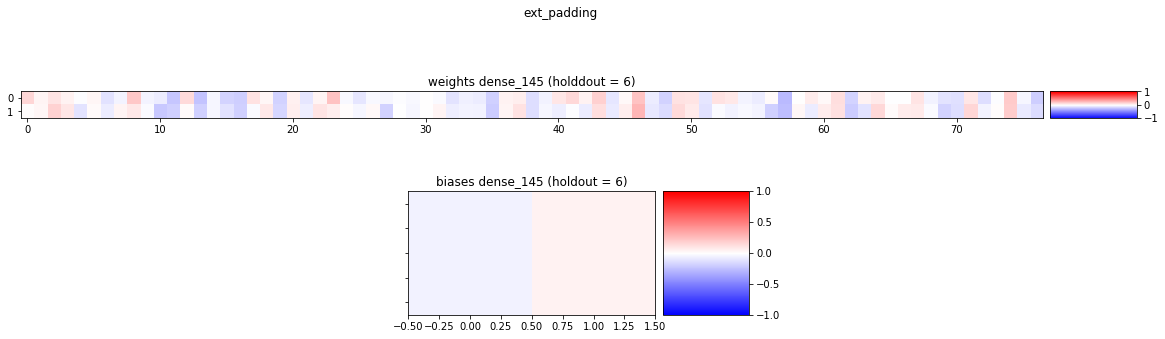

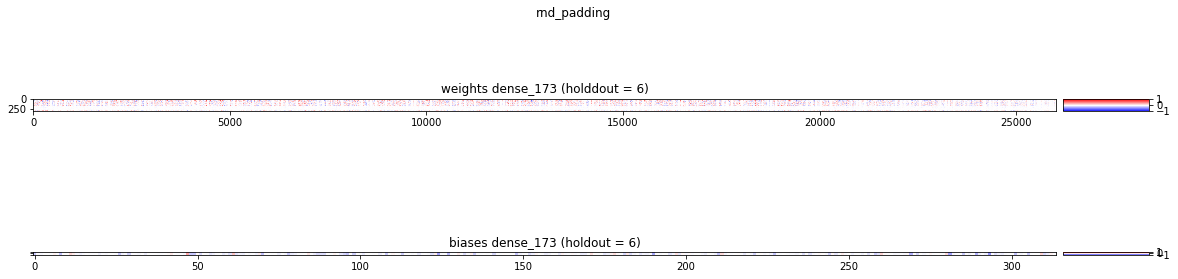

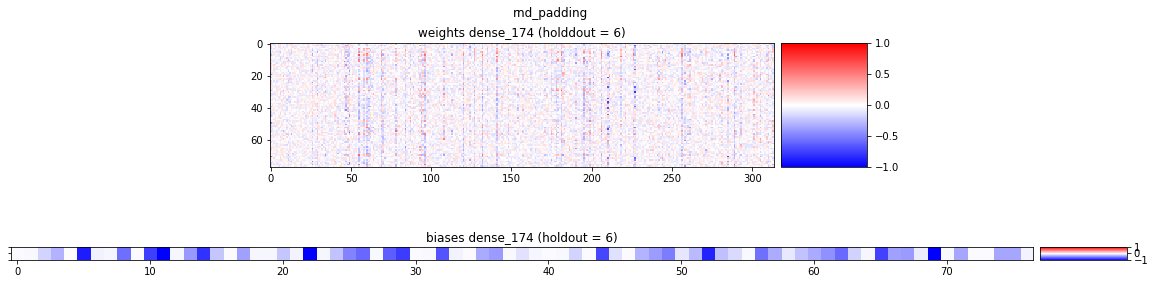

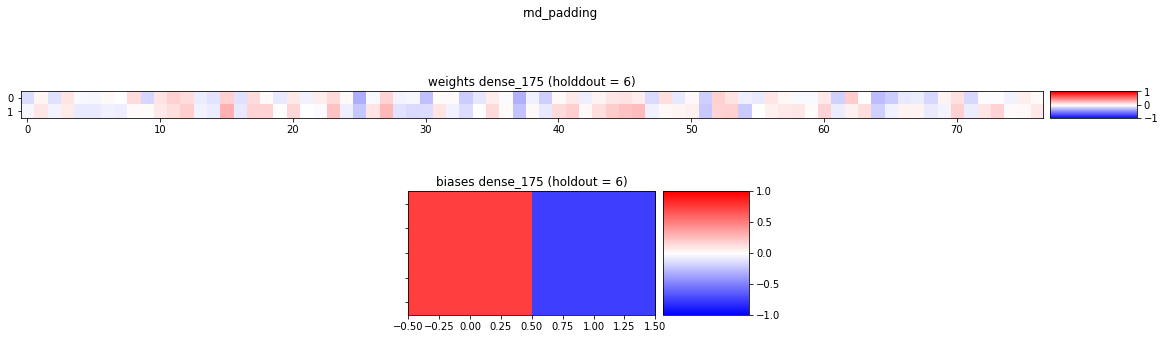

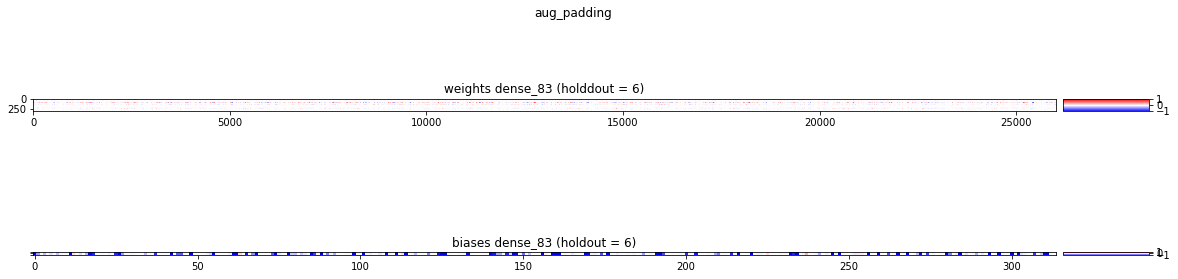

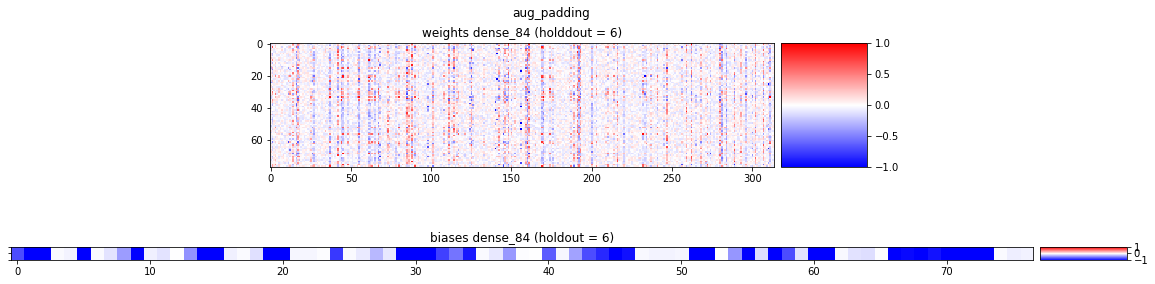

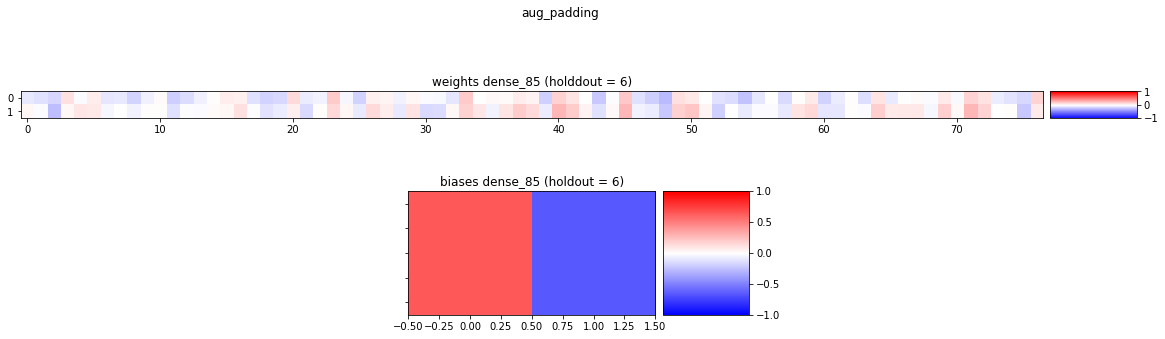

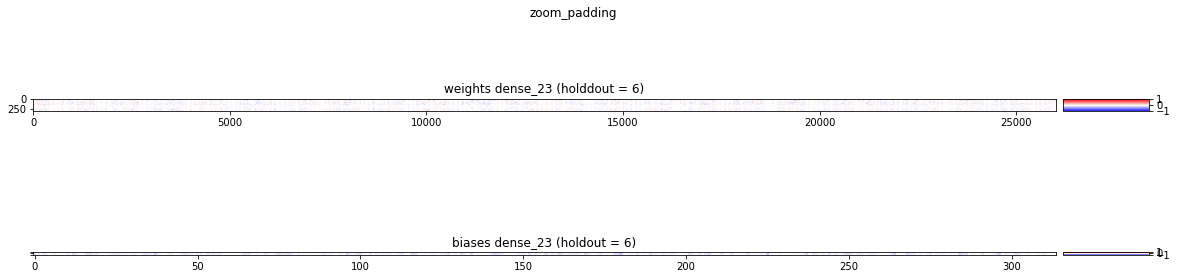

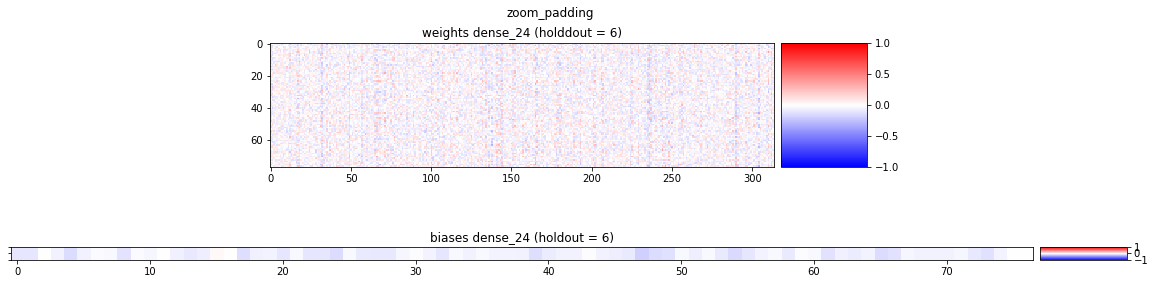

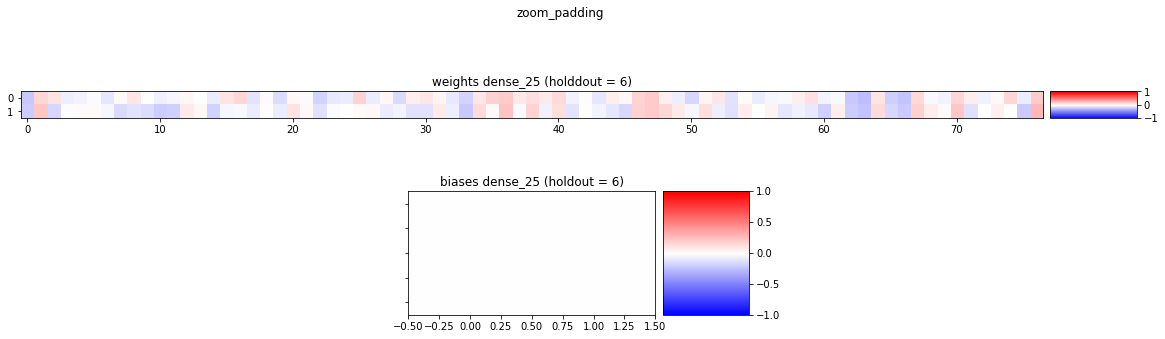

In [29]:
k = random.randint(0, 9)

for type_padding in list_paddings:
    #for k in range(10):
    path_k = str(k) +"/"
    model_paths = os.path.join(absPath, 'data/checkpoint/', folder, task, type_padding, path_k)
    model_file = os.listdir(model_paths)[0]
    #Loading best model
    with tf.device('/cpu:0'):
        model = load_model(os.path.join(model_paths, model_file))
    layers_names = [layer.name for layer in model.layers]
    layers_to_plot = [i for i in layers_names if i.startswith("dense")]
    weights_to_plot = [model.get_layer(i).get_weights()[0] for i in layers_to_plot]
    biases_to_plot = [model.get_layer(i).get_weights()[1] for i in layers_to_plot]
    
    for idx,layer in enumerate(layers_to_plot):
        layer_weights = weights_to_plot[idx]
        layer_biases = biases_to_plot[idx]
        #processing weights
        w = np.swapaxes(layer_weights,0,1)
        #processing biases
        shape_b = layer_biases.shape[0]
        b = np.reshape(layer_biases, (shape_b,1))
        b = np.swapaxes(b,0,1)
        #plotting
        fig, axs = plt.subplots(2, figsize=(20, 5))
        fig.suptitle('%s' %type_padding)
        #axs[0] = pl.gca()
        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes("right", 1.2, pad=0.1)
        im = axs[0].imshow(w, vmin=-1, vmax=1, interpolation='nearest', cmap=cm.bwr)
        pl.colorbar(im, cax=cax)
        axs[0].title.set_text('weights %s (holddout = %s)' %(layers_to_plot[idx], str(k)))
        #biases
        divider = make_axes_locatable(axs[1])
        cax = divider.append_axes("right", 1.2, pad=0.1)        
        im = axs[1].imshow(b, vmin=-1, vmax=1, interpolation='nearest', cmap=cm.bwr)
        pl.colorbar(im, cax=cax)
        axs[1].title.set_text('biases %s (holdout = %s)' %(layers_to_plot[idx], str(k)))
        pl.setp(axs[1].get_yticklabels(), visible=False)

In [39]:
lista_dicts = []
for type_padding in list_paddings:
    # building PCA with the weights of the biggest layer (if I put all the weights this is the one that will be 
    # really seen)
    path_k = str(k) +"/"
    model_paths = os.path.join(absPath, 'data/checkpoint/', folder, task, type_padding, path_k)
    model_file = os.listdir(model_paths)[0]
    #Loading best model
    with tf.device('/cpu:0'):
        model = load_model(os.path.join(model_paths, model_file))
    layers_names = [layer.name for layer in model.layers]
    layers_to_plot = [i for i in layers_names if i.startswith("dense")]
    weights_to_plot = [model.get_layer(i).get_weights()[0] for i in layers_to_plot]
    #biases_to_plot = [model.get_layer(i).get_weights()[1] for i in layers_to_plot] 
    weights_selected = weights_to_plot[0].flatten()
    name_seq = ["weights_"+str(i) for i in range(1,len(weights_selected)+1)]
    dicti = {n: d for n, d in zip(name_seq, weights_selected)} 
    dicti.update({'type_padding': type_padding})
    lista_dicts.append(dicti)

weights_df = pd.DataFrame(lista_dicts)
print(weights_df.head())
print(weights_df.info())

   type_padding  weights_1  weights_10  weights_100  weights_1000  \
0  post_padding  -0.006189    0.005555    -0.014662      0.010748   
1   pre_padding  -0.019145   -0.031196    -0.016673      0.001806   
2   mid_padding  -0.004260   -0.006786    -0.006773      0.001075   
3  strf_padding  -0.003825   -0.016738    -0.303672     -0.011161   
4   ext_padding  -0.030382   -0.001976    -0.012302      0.004052   

   weights_10000  weights_100000  weights_1000000  weights_1000001  \
0      -0.022248        0.012399         0.012277         0.449196   
1       0.015023       -0.006908        -0.014237        -0.006552   
2       0.090217       -0.012702        -0.010946         0.025478   
3      -0.011109       -0.082489        -0.005582        -0.001690   
4      -0.003631       -0.004097        -0.004390         0.009398   

   weights_1000002  ...  weights_999990  weights_999991  weights_999992  \
0         0.066198  ...       -0.000577        0.020920        0.397512   
1         0.00

In [96]:
#preparing data 
npdesc = weights_df.drop(['type_padding'], axis=1).values
scaler = preprocessing.StandardScaler().fit(npdesc)
npdesc = scaler.transform(npdesc)

typePadding_list = weights_df.loc[:, 'type_padding'].values

In [40]:
#training PCA
pca = PCA(n_components=2)
pca.fit(npdesc)
    
pc_tr = pca.transform(npdesc)
    
print("Explained variance by principal components are %s" % pca.explained_variance_ratio_)

Explained variance by principal components are [ 0.24412049  0.17027959]


In [97]:
labs = ['post_padding', 'pre_padding', 'mid_padding', 'strf_padding', 'ext_padding', 
        'rnd_padding', 'aug_padding', 'zoom_padding']
dict_paddings = {'post_padding':0, 'pre_padding':1, 'mid_padding':2, 'strf_padding':3, 'ext_padding':4, 
        'rnd_padding':5, 'aug_padding':6, 'zoom_padding':7}  
typePadding_translated = [dict_paddings[i] for i in list(typePadding_list)]

In [101]:
np.asarray(typePadding_translated)[:, None]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7]])

In [99]:
pc_tr

array([[ -744.13876231,  1150.24799864],
       [ -439.18612997,  -216.40095131],
       [  527.27106179,  -115.0499416 ],
       [ -733.2453508 , -1482.37393681],
       [ -445.34403654,  -195.15501142],
       [ -723.347276  , -1577.69198608],
       [ 3558.08348411,   206.91226192],
       [-1000.09299028,  2229.51156666]])

array([[ -7.44138762e+02,   1.15024800e+03,   0.00000000e+00],
       [ -4.39186130e+02,  -2.16400951e+02,   1.00000000e+00],
       [  5.27271062e+02,  -1.15049942e+02,   2.00000000e+00],
       [ -7.33245351e+02,  -1.48237394e+03,   3.00000000e+00],
       [ -4.45344037e+02,  -1.95155011e+02,   4.00000000e+00],
       [ -7.23347276e+02,  -1.57769199e+03,   5.00000000e+00],
       [  3.55808348e+03,   2.06912262e+02,   6.00000000e+00],
       [ -1.00009299e+03,   2.22951157e+03,   7.00000000e+00]])

Text(0.5, 1.0, 'PCA weights Dense_1')

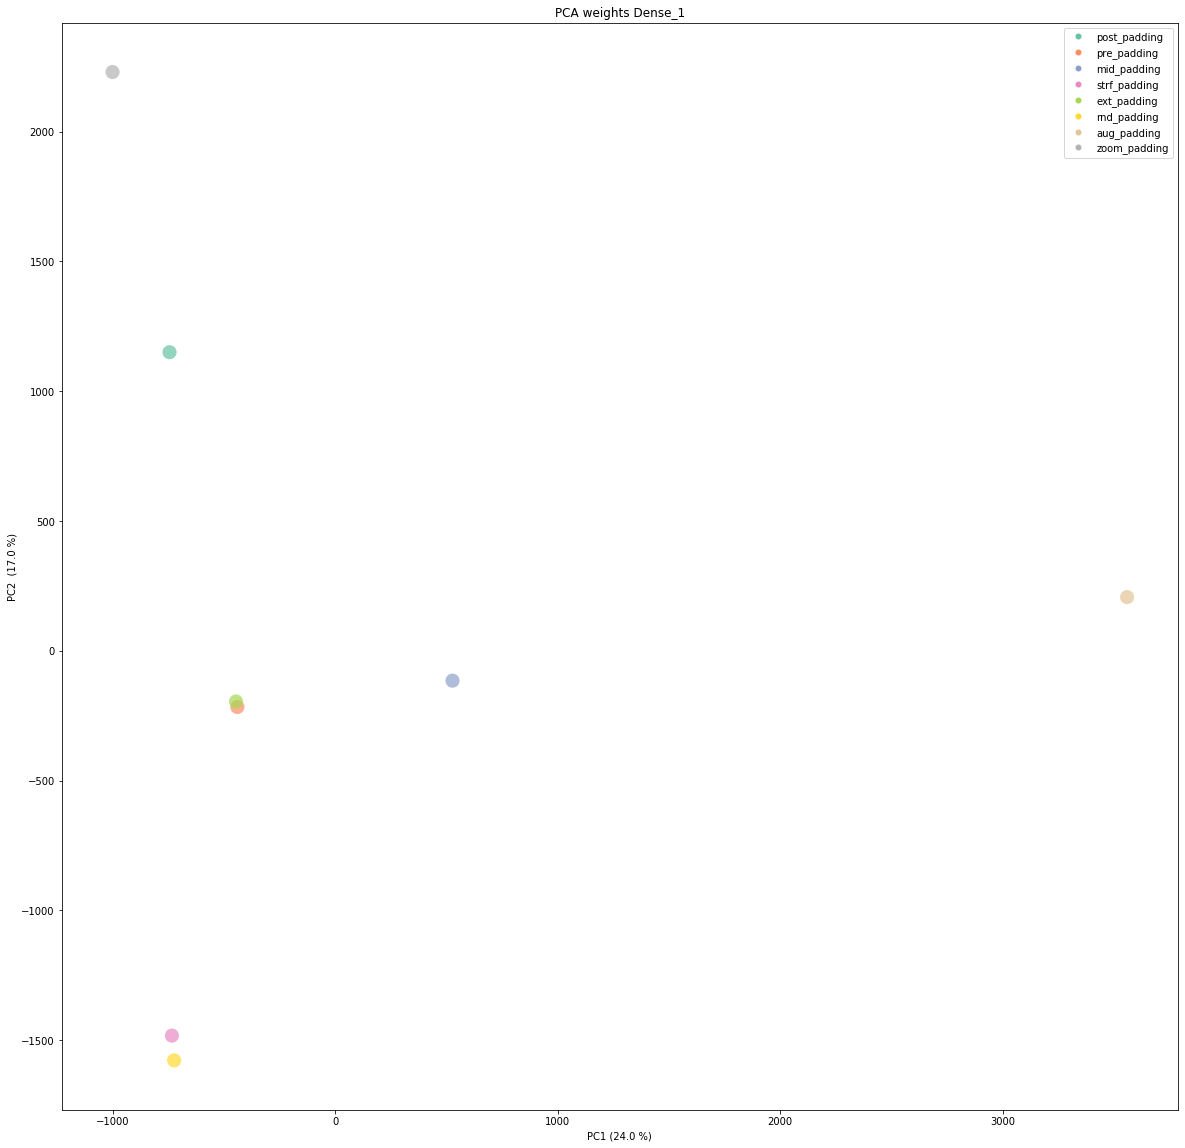

In [109]:
explained_variances = pca.explained_variance_ratio_
pc1 = str(round(explained_variances[0]*100))
pc2 = str(round(explained_variances[1]*100))
fig, ax = plt.subplots(figsize=(20,20))
cm = plt.get_cmap('Set2')
pc_tr_l = np.concatenate((pc_tr, np.asarray(typePadding_translated)[:, None]), axis=1)
sc = ax.scatter(pc_tr_l[:,0], pc_tr_l[:,1], c=typePadding_translated, edgecolor='none', alpha=0.7, cmap=cm, s=200)
lp = lambda i: ax.plot([],color=cm(sc.norm(i)), mec="none", label=labs[i], ls="", marker="o")[0]
handles = [lp(i) for i in np.unique(typePadding_translated)]
ax.legend(handles=handles)
ax.set(xlabel="PC1 (%s %%)" %pc1,ylabel="PC2  (%s %%)" %pc2)
ax.set_title('PCA weights Dense_1' )a
